# Predicting used car prices

[Kaggle](https://www.kaggle.com/avikasliwal/used-cars-price-prediction) dataset about used cars and their prices was used.

## Import libraries

Import `datetime` to handle year, `numpy` to work with arrays and `pandas` to read in the dataset files, `matplotlib` & `seaborn` for plotting and `sklearn` for various machine learning models.

In [606]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## Read dataset

Reading the dataset and getting information about it.

In [607]:
dataset = pd.read_csv("data/dataset.csv")
dataset.head(5)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


Spliting the dataset into train and test datasets.

In [608]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], 
                                                    dataset.iloc[:, -1], 
                                                    test_size = 0.5, 
                                                    random_state = 42)

In [609]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5417 entries, 742 to 860
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5417 non-null   int64  
 1   Name               5417 non-null   object 
 2   Location           5417 non-null   object 
 3   Year               5417 non-null   int64  
 4   Kilometers_Driven  5417 non-null   int64  
 5   Fuel_Type          5417 non-null   object 
 6   Transmission       5417 non-null   object 
 7   Owner_Type         5417 non-null   object 
 8   Mileage            5416 non-null   object 
 9   Engine             5383 non-null   object 
 10  Power              5383 non-null   object 
 11  Seats              5379 non-null   float64
 12  New_Price          736 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 592.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 2868 to 2671
Data columns (total 13 columns):

## Cleaning the given data

### Index

The first column is the index for each data point and hence we can simply remove it.

In [610]:
X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]

### Name

Let's explore the various cars in the dataset.

In [611]:
X_train["Name"].value_counts()

Mahindra XUV500 W8 2WD                   43
Maruti Swift VDI                         43
Honda City 1.5 S MT                      31
Hyundai i10 Sportz                       30
Maruti Swift Dzire VDI                   29
                                         ..
BMW 3 Series GT 320d Luxury Line          1
Tata Tigor 1.05 Revotorq XZ Option        1
Hyundai Creta 1.6 SX Automatic Diesel     1
Audi Q5 2.0 TDI Technology                1
Ford Endeavour 2.2 Titanium AT 4X2        1
Name: Name, Length: 1787, dtype: int64

Sometimes the resale value of a car also depends on manufacturer of car and so we extracted the manufacturer from this column and added it to the dataset.

In [612]:
make_train = X_train["Name"].str.split(" ", expand = True)
make_test = X_test["Name"].str.split(" ", expand = True)

In [613]:
X_train["Manufacturer"] = make_train[0]
X_test["Manufacturer"] = make_test[0]

Let's also confirm that there are no null values and identify all unique values.

Text(0, 0.5, 'Count of cars')

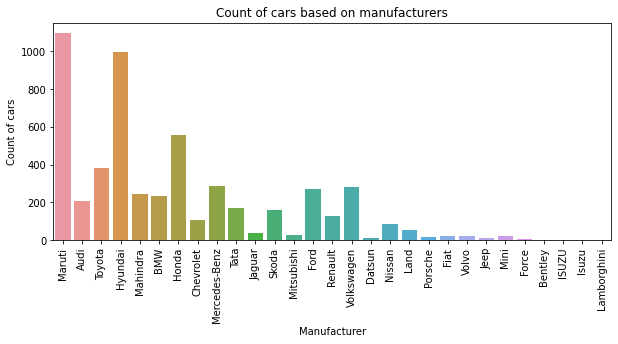

In [614]:
plt.figure(figsize = (10, 4))
plot = sns.countplot(x = 'Manufacturer', data = X_train)
plt.xticks(rotation = 90)

plt.title("Count of cars based on manufacturers")
plt.ylabel("Count of cars")

Dropping the name and location column

In [615]:
X_train.drop("Name", axis = 1, inplace = True)
X_test.drop("Name", axis = 1, inplace = True)
X_train.drop("Location", axis = 1, inplace = True)
X_test.drop("Location", axis = 1, inplace = True)

### Year

Year has no significance on its own unless we try to extract how old a car is from this and see how its resale price may get affected.

In [616]:
curr_time = datetime.datetime.now()
X_train['Year'] = X_train['Year'].apply(lambda x : curr_time.year - x)
X_test['Year'] = X_test['Year'].apply(lambda x : curr_time.year - x)

### Fuel_Type, Transmission,  and Owner_Type

All these columns are categorical columns which should be converted to dummy variables before being used.

### Kilometers_Driven

`Kilometers_Driven` is a numerical column with a certain range of values.

In [617]:
X_train["Kilometers_Driven"]

742      35214
4105     71000
4393    111000
2638     90400
1608     68630
         ...  
3772     27000
5191      9000
5226    140000
5390     76414
860      98000
Name: Kilometers_Driven, Length: 5417, dtype: int64

The data range is really varied and the high values might affect prediction, thus, it is really important that scaling be applied to this column for sure.

## Mileage

This column defines the mileage of the car. We need to extract the numerical value out of each string and save it.
Coerce will set the missing values to NaN.

In [618]:
mileage_train = X_train["Mileage"].str.split(" ", expand = True)
mileage_test = X_test["Mileage"].str.split(" ", expand = True)

X_train["Mileage"] = pd.to_numeric(mileage_train[0], errors = 'coerce')
X_test["Mileage"] = pd.to_numeric(mileage_test[0], errors = 'coerce')

Checking for missing values and replacing them with mean value of column from training data.

In [619]:
print(sum(X_train["Mileage"].isnull()))
print(sum(X_test["Mileage"].isnull()))
X_train["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)
X_test["Mileage"].fillna(X_train["Mileage"].astype("float64").mean(), inplace = True)

1
1


### Engine, Power and Seats

The `Engine` values are defined in CC so we need to remove `CC` from the data. Similarly, `Power` has bhp, so we will remove `bhp` from it. Also, as there are missing values in `Engine`, `Power` and `Seats`, we will again replace them with the mean.

In [620]:
cc_train = X_train["Engine"].str.split(" ", expand = True)
cc_test = X_test["Engine"].str.split(" ", expand = True)
X_train["Engine"] = pd.to_numeric(cc_train[0], errors = 'coerce')
X_test["Engine"] = pd.to_numeric(cc_test[0], errors = 'coerce')

bhp_train = X_train["Power"].str.split(" ", expand = True)
bhp_test = X_test["Power"].str.split(" ", expand = True)
X_train["Power"] = pd.to_numeric(bhp_train[0], errors = 'coerce')
X_test["Power"] = pd.to_numeric(bhp_test[0], errors = 'coerce')

Setting NaN values to mean of their respective columns

In [621]:
X_train["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)
X_test["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)

X_train["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)
X_test["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)

X_train["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)
X_test["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)

### New Price

As most of the values are missing this column is being dropped.

In [622]:
X_train.drop(["New_Price"], axis = 1, inplace = True)
X_test.drop(["New_Price"], axis = 1, inplace = True)

## Data Processing

Now that we have worked with the training data, let's create dummy columns for categorical columns before we begin training.

In [623]:
X_train = pd.get_dummies(X_train,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)
X_test = pd.get_dummies(X_test,
                         columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],
                         drop_first = True)

Normalizing columns in training and testing dataset 

In [624]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

## Scaling the data

In [625]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train = standardScaler.transform(X_train)
X_test = standardScaler.transform(X_test)

## Training and predicting

**Linear Regression** model model to train on the data and use it for future predictions.

In [626]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)


## Scoring of linear regression model

*R^2 model is used to score the model*


In [627]:
r2_score(y_test, y_pred)

0.7637264861197913

ValueError: x and y must be the same size

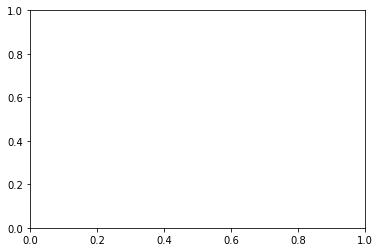

In [628]:
plt.scatter(X_train, y_train,color='g')
plt.plot(X_train, y_pred,color='k')

plt.show()